# Data Clean up

Haytham Mohamed - INFS890 Spring 2020

This notebook is to clean orders flow data

In [1476]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn import preprocessing
from datetime import datetime
from scipy import stats

sns.set()
sns.set(color_codes=True)
#sns.set_color_codes()

pd.options.display.max_rows = 15
pd.options.display.float_format = '{:,.2f}'.format

# Read the raw data. 

All data is in one file, where each metric is listed under each other with three columns: 

1- metric: The name of the metric

2- date: the data and time of the metric

3- value: the metric value


In [1477]:
# 1- read processed file

home_dir = '/Users/hmohamed/github/data-research-spring2020/sock-shop'

file_dir = home_dir + '/processed-data/'
input_file = 'orders_flow_data.csv'

save=True

In [1478]:
def read_df(file_dir, data_file):
    df = pd.read_csv(file_dir + data_file)
    return to_time_series(df)

def to_time_series(df, index_col_name='date'):
    df[index_col_name] = pd.to_datetime(df[index_col_name])
    df.set_index(index_col_name, inplace=True)
    df.sort_index(inplace=True)
    return df
    

In [1479]:
orders_flow_df = read_df(file_dir, input_file)
orders_flow_df.head(5) 

,front-end_cpu_use,orders_cpu_use,orders-db_cpu_use,user_cpu_use,user-db_cpu_use,shipping_cpu_use,payment_cpu_use,carts_cpu_use,carts-db_cpu_use,front-end_pods,orders_pods,user_pods,shipping_pods,payment_pods,carts_pods,nodes_cpu_use,orders_req,orders_ltcy
date,,,,,,,,,,,,,,,,,,
2020-03-26 19:46:22,0.03,0.01,0.01,0.01,0.01,0.01,0.01,0.03,0.07,1.00,1.00,1.00,1.00,1.00,1.00,2.50,0.15,0.24
2020-03-26 19:46:37,0.06,0.02,0.02,0.02,0.02,0.01,0.01,0.18,0.18,1.00,1.00,1.00,1.00,1.00,1.00,1.89,0.15,0.24
2020-03-26 19:46:52,0.07,0.03,0.02,0.03,0.02,0.01,0.01,0.44,0.20,1.00,1.00,1.00,1.00,1.00,1.00,1.35,0.15,0.24
2020-03-26 19:47:07,0.07,0.03,0.02,0.02,0.02,0.01,0.01,0.23,0.17,1.00,1.00,1.00,1.00,1.00,1.00,1.26,0.13,0.24
2020-03-26 19:47:22,0.07,0.02,0.01,0.02,0.02,0.01,0.01,0.24,0.14,1.00,1.00,1.00,1.00,1.00,1.00,1.28,0.36,0.24


In [1480]:
orders_flow_df.shape


(6766, 18)

Take away records with ltcy or number of pods null or equals to zero

In [1481]:
orders_flow_df = orders_flow_df[orders_flow_df['orders_ltcy'].notna()]
orders_flow_df.shape

(6766, 18)

In [1482]:
orders_flow_df = orders_flow_df[orders_flow_df['orders_ltcy'] >= 0]
orders_flow_df.shape

(6766, 18)

In [1483]:
orders_flow_df.describe(include="all")

/opt/anaconda3/envs/infs890/lib/python3.7/site-packages/IPython/core/displayhook.py:276: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  'Flushing oldest {cull_count} entries.'.format(sz=sz, cull_count=cull_count))


,front-end_cpu_use,orders_cpu_use,orders-db_cpu_use,user_cpu_use,user-db_cpu_use,shipping_cpu_use,payment_cpu_use,carts_cpu_use,carts-db_cpu_use,front-end_pods,orders_pods,user_pods,shipping_pods,payment_pods,carts_pods,nodes_cpu_use,orders_req,orders_ltcy
count,"6,766.00","6,766.00","6,766.00","6,766.00","6,766.00","6,766.00","6,766.00","6,766.00","6,766.00","6,766.00","6,766.00","6,766.00","6,766.00","6,766.00","6,766.00","6,766.00","6,766.00","6,766.00"
mean,0.83,0.21,0.02,0.20,0.12,0.05,0.03,0.53,1.83,2.76,2.76,2.76,2.76,2.76,2.76,4.10,5.03,2.97
std,0.62,0.13,0.00,0.13,0.08,0.04,0.01,0.58,1.99,1.10,1.09,1.09,1.09,1.09,1.09,2.08,4.20,3.51
min,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.03,0.01,0.50,1.00,1.00,1.00,1.00,1.00,1.10,0.00,0.02
25%,0.19,0.08,0.02,0.05,0.03,0.04,0.02,0.12,0.02,2.00,2.00,2.00,2.00,2.00,2.00,1.92,0.49,0.24
50%,0.84,0.22,0.02,0.20,0.12,0.05,0.03,0.32,1.15,3.00,3.00,3.00,3.00,3.00,3.00,4.21,5.14,0.49
75%,1.29,0.30,0.02,0.30,0.18,0.06,0.04,0.58,3.28,4.00,4.00,4.00,4.00,4.00,4.00,5.78,8.20,5.81
max,2.73,0.91,0.04,0.64,0.34,0.63,0.10,2.53,6.58,4.00,4.00,4.00,4.00,4.00,4.00,9.66,20.13,9.75


# Check missing values

In [1484]:
# percent of missing value for every feature
orders_flow_df.isnull().sum() * 100 / orders_flow_df.shape[0]

front-end_cpu_use   0.00
orders_cpu_use      0.00
orders-db_cpu_use   0.00
user_cpu_use        0.00
user-db_cpu_use     0.00
                    ... 
payment_pods        0.00
carts_pods          0.00
nodes_cpu_use       0.00
orders_req          0.00
orders_ltcy         0.00
Length: 18, dtype: float64

# Check Outliers

### latency target 

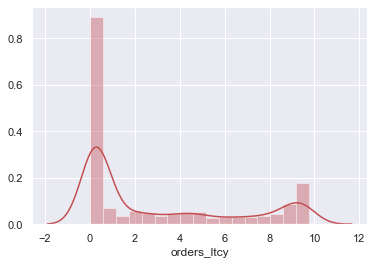

In [1485]:
sns.distplot(orders_flow_df['orders_ltcy'], hist=True, rug=False, color="r", label='ltcy')

latency quantiles min 7.43360448807854 max 0.24
request rate quantiles min 9.6 max 0.0


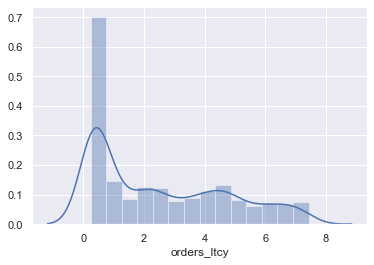

In [1486]:
# taking percentile out (between lower and upper limit)
# looks like first half of latency is between 0.24 and 1.361, the other half is 2 and up to 9.7
# acceptable outliers in services latency, I'll consider it. so take all data (0 to 100%)
# i.e. not to trim any portion from either edges

# latency
df2 = orders_flow_df
if 1 == 1:
    minq = df2['orders_ltcy'].quantile(0.2)
    maxq = df2['orders_ltcy'].quantile(0.8)
    print('latency quantiles min {} max {}'.format(maxq, minq))
    df2 = df2[df2['orders_ltcy'] > minq]
    df2 = df2[df2['orders_ltcy'] < maxq]
    sns.distplot(df2['orders_ltcy'])
    
# request rate
if 1 == 1:
    minq = df2['orders_req'].quantile(0)
    maxq = df2['orders_req'].quantile(.9)
    print('request rate quantiles min {} max {}'.format(maxq, minq))
    df2 = df2[df2['orders_req'] > minq]
    df2 = df2[df2['orders_req'] < maxq]
    #sns.distplot(df2['orders_req'])

The scaled latency distribution shows now an exponential graph. Taking the log and plotting it would remedy the skewness.

In [1487]:
df2.shape

(1499, 18)

In [1488]:
df2.describe(include="all")

,front-end_cpu_use,orders_cpu_use,orders-db_cpu_use,user_cpu_use,user-db_cpu_use,shipping_cpu_use,payment_cpu_use,carts_cpu_use,carts-db_cpu_use,front-end_pods,orders_pods,user_pods,shipping_pods,payment_pods,carts_pods,nodes_cpu_use,orders_req,orders_ltcy
count,"1,499.00","1,499.00","1,499.00","1,499.00","1,499.00","1,499.00","1,499.00","1,499.00","1,499.00","1,499.00","1,499.00","1,499.00","1,499.00","1,499.00","1,499.00","1,499.00","1,499.00","1,499.00"
mean,0.97,0.26,0.02,0.22,0.14,0.06,0.03,0.38,3.37,2.40,2.41,2.41,2.41,2.41,2.41,5.46,5.83,1.43
std,0.39,0.10,0.01,0.09,0.06,0.04,0.01,0.18,2.04,1.05,1.04,1.04,1.04,1.04,1.04,1.70,2.93,1.72
min,0.06,0.02,0.01,0.02,0.02,0.01,0.01,0.04,0.01,0.50,1.00,1.00,1.00,1.00,1.00,1.15,0.04,0.25
25%,0.81,0.22,0.02,0.18,0.11,0.05,0.02,0.29,1.25,2.00,2.00,2.00,2.00,2.00,2.00,4.58,3.37,0.32
50%,1.03,0.27,0.02,0.25,0.16,0.06,0.03,0.37,3.94,2.00,2.00,2.00,2.00,2.00,2.00,5.72,6.71,0.45
75%,1.25,0.31,0.03,0.28,0.18,0.07,0.04,0.43,4.96,3.00,3.00,3.00,3.00,3.00,3.00,6.64,8.29,2.19
max,2.26,0.91,0.04,0.52,0.28,0.63,0.10,2.16,6.50,4.00,4.00,4.00,4.00,4.00,4.00,9.07,9.58,7.43


In [1489]:
orders_flow_df = df2
if save:
    processed_file_path = file_dir + 'order_flow_cleanup_data.csv'
    orders_flow_df.to_csv(path_or_buf=processed_file_path, index=True)
    
orders_flow_df.head(5)    

,front-end_cpu_use,orders_cpu_use,orders-db_cpu_use,user_cpu_use,user-db_cpu_use,shipping_cpu_use,payment_cpu_use,carts_cpu_use,carts-db_cpu_use,front-end_pods,orders_pods,user_pods,shipping_pods,payment_pods,carts_pods,nodes_cpu_use,orders_req,orders_ltcy
date,,,,,,,,,,,,,,,,,,
2020-03-26 19:48:22,0.07,0.02,0.01,0.02,0.02,0.01,0.01,0.12,0.16,1.00,1.00,1.00,1.00,1.00,1.00,1.18,0.40,0.40
2020-03-26 19:48:37,0.06,0.03,0.01,0.02,0.02,0.01,0.01,0.14,0.17,1.00,1.00,1.00,1.00,1.00,1.00,1.18,0.44,0.39
2020-03-26 19:48:52,0.06,0.03,0.01,0.02,0.02,0.01,0.01,0.15,0.14,1.00,1.00,1.00,1.00,1.00,1.00,1.15,0.36,0.38
2020-03-26 19:51:22,0.09,0.03,0.01,0.02,0.02,0.01,0.01,0.06,0.19,1.00,1.00,1.00,1.00,1.00,1.00,1.54,0.40,0.31
2020-03-26 19:51:37,0.11,0.04,0.01,0.03,0.03,0.01,0.01,0.11,0.32,1.00,1.00,1.00,1.00,1.00,1.00,2.35,0.78,0.28
